In [1]:
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np
import collections as cls
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import math
import glob
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from matplotlib import pylab
from pylab import *
random_state = 10

In [2]:
#get all city names
all_cities_paths =  glob.glob(os.path.join(os.getcwd(), 'data','*'))
cities = []
for city in all_cities_paths:
    cities.append(city.split("/")[-1])
print(cities)
                    

['amsterdam', 'berlin', 'copenhagen', 'dublin', 'edinburgh', 'helsinki', 'lisbon', 'london', 'madrid', 'moscow', 'rome', 'tallin', 'vienna', 'paris', 'reykjavik']


In [3]:
#finds the not common elements of the two lists
#input: list1,list2 --> the lists to be compared
#output: the not common elements
def find_not_common_columns(list1,list2):
    not_common_cols = []
    both_lists = list1 + list2
    for col in set(both_lists):
        if col not in set(list1) or col not in set(list2):
            not_common_cols.append(col)
    return not_common_cols



In [4]:
#loading each city's dataset to a dictionary and stripping their column titles from unwanted characters
#moreover checking which columns are not common for all csv files of a particular city in order to be discarded later
#in addition their last_modified column values are stripped
datasets = dict()
for city in cities:
    city_data = pd.DataFrame() #initializing city's dataframe
    data_path = glob.glob(os.path.join(os.getcwd(), 'data',city,city,city,'*.csv'))
    print('\n\n\n{}\n'.format(city))
    first = True
    file_columns = [] #containing the columns that the first file of the particular city contains
    for f in data_path:
        file_data =pd.read_csv(f,delimiter=",",lineterminator="\n") 
        old_columns = list(file_data.columns.values)
        new_columns = [] #containing the columns after the stripping
        for col in old_columns:
            new_columns.append(col.strip())
        if first:
            file_columns = new_columns
            first = False
        else:
            if file_columns == new_columns:
                print('no difference in the columns')
            else:
                print('DIFFERENCE IN THE COLUMNS REPORTED')
                print('NOT COMMON COLUMNS: {}'.format(find_not_common_columns(file_columns,new_columns)))      
        file_data.columns = new_columns
        file_data['last_modified'] = file_data['last_modified'].apply(lambda x: x.strip()) #stripping all the values of 'last_modified' column
        city_data = pd.concat([city_data,file_data],ignore_index=True)
    print('\n{}\'s dataset length: {}'.format(city,len(city_data.index)))
    #city_data.fillna("(unknown)",inplace=True)
    datasets[city] = city_data




amsterdam

no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
DIFFERENCE IN THE COLUMNS REPORTED
NOT COMMON COLUMNS: ['survey_id', 'bathrooms', 'city', 'country', 'location', 'name']
DIFFERENCE IN THE COLUMNS REPORTED
NOT COMMON COLUMNS: ['survey_id', 'bathrooms', 'city', 'country', 'location', 'name']

amsterdam's dataset length: 184551



berlin

no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
no difference in the columns
D

In [5]:
#find out which of the columns of each city's dataset have missing values 
#and delete the columns that have only missing values
city_columns = dict() #it is going to conatin the feature list of each city
for city in datasets.keys():
    city_data = datasets[city]
    all_data = len(city_data.index)
    columns = city_data.columns.values
    city_columns[city] = list(columns)
    some_mis = dict()
    only_mis = []
    for col in columns:
        #bools = data[col].to_frame().isin({col: ['(unknown)']}) 
        bools = city_data[col].to_frame().isnull()
        num = len(bools[bools[col] == True].index) #number of mssing values in the particular column
        if num > 0: #if there is at least one missing value
            if num < len(city_data[col].index): #if not all values are missing
                some_mis[col] = num
            else:
                only_mis.append(col) #if all values of the column are missing
    print_str = '\n{} '.format(city)
    if len(some_mis.keys()) > 0:
        first = True
        for col in some_mis.keys():
            if first:
                first = False
                print_str += '\ncols with some missing values--> {}({}%)'.format(col,100*float(some_mis[col]/all_data))
            else:
                print_str += ',{}({}%)'.format(col,100*float(some_mis[col]/all_data))
    if len(only_mis) > 0:
        print_str += '\ncols with only missing values--> {}'.format(only_mis[0])
        for i in range(1,len(only_mis)):
            print_str += ',{}'.format(only_mis[i])
        city_data.drop(only_mis, axis=1, inplace=True) #deleting columns with only missing data
        datasets[city] = city_data
    print(print_str)
        
    


edinburgh 
cols with some missing values--> overall_satisfaction(13.393982944%),city(69.7384655016%),name(69.7411771086%),price(0.00271160703391%),bedrooms(0.139647762246%),accommodates(1.75712135797%),minstay(72.1260354949%),location(69.7384655016%),survey_id(69.7384655016%),room_type(0.00677901758477%)
cols with only missing values--> bathrooms,borough,country

reykjavik 
cols with some missing values--> city(78.223078474%),price(0.0201617419745%),bedrooms(9.57010685723%),overall_satisfaction(16.4363000963%),minstay(57.7745917247%),location(78.223078474%),survey_id(78.223078474%),room_type(0.0201617419745%)
cols with only missing values--> bathrooms,borough,country

helsinki 
cols with some missing values--> city(64.1407968712%),survey_id(64.1407968712%),name(64.3241261305%),bedrooms(0.0427768271816%),overall_satisfaction(12.1425079443%),minstay(88.1935956979%),location(64.1407968712%),property_type(64.1407968712%)
cols with only missing values--> bathrooms,borough,country

paris 
c

In [6]:
df = pd.DataFrame([[1, 2, 2, 0], [2, np.nan, 3, 1], [3, 4, 3, 1], [2, 4, 3, 1], [2, 4, 3, 1],
                   [3, np.nan, 3, 1], [3, 4, 3, 1]],columns=list('ABCD'))
col='B'
null_entries = df[['A']][df['B'].isnull()]
for index,row in null_entries.iterrows():
    same_room_entries = df[[col]][df['A'] == row['A']] #get the rest of the 
    if len(same_room_entries.index) > 0:
        df.set_value(index,col,same_room_entries[col].median())

df['B'][0]

2.0

In [7]:
#dealing with the columns which contain both missing and normal entries
columns_to_delete = ['city','location','survey_id','name','minstay']
#city is not needed
#location is not needed
#survey_id is not needed
#name is not needed
#minstay have too many null values to be saved 

delete_null_entries = ['price']
#these columns' values are too significant and they might change from time to time even for the same room
#as a result it seems wiser to delete the entries where these columns are null rather than replace them
#accommodates will be dealt with later

replace_nulls_median = ['bedrooms','overall_satisfaction']
#given the fact that generally the same room appears multiple times inside each city's dataset these columns are going 
#to be replaced by the median of the column values inside the same room through time

replace_nulls_value = ['room_type','host_id']
#if the same room_id exists in the dataset with a non-null value for these fields then the null value is replaced 
#by that. If not the entries containing null values are removed

for city in datasets.keys():
    print('\n{}'.format(city))
    city_data = datasets[city]
    for col in columns_to_delete:
        if col in city_data.columns:
            city_data.drop([col], axis=1, inplace=True) #columns_to_delete are deleted
    old_num = len(city_data.index)
    
    for col in delete_null_entries:
        if col in city_data.columns:
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries of delete_null_entries are deleted
        print('\n{}:\t{} values were deleted'.format(
                col,len(city_data[city_data[col].isnull()].index)))
            
    for col in replace_nulls_median:
        if col in city_data.columns:
            null_entries = city_data[['room_id']][city_data[col].isnull()]
            count = 0
            for index,row in null_entries.iterrows():
                same_room_entries = city_data[[col]][city_data['room_id'] == row['room_id']] 
                #get the rest of the entries of the particular room where the nul appeared
                if len(same_room_entries.index) > 0:
                    city_data.set_value(index,col,same_room_entries[col].median())
                    count += 1
                    #replacing the null value with the median of the values for the same room_id
            print('\n{}:\t{} values were replaced\t{} were not replaced and were deleted'.format(
                col,count,len(city_data[city_data[col].isnull()].index)))
            
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries that were not replaced are deleted
    
    for col in replace_nulls_value:
        if col in city_data.columns:
            null_entries = city_data[['room_id']][city_data[col].isnull()]
            count = 0
            for index,row in null_entries.iterrows():
                same_room_entries = city_data[col][city_data['room_id'] == row['room_id']] 
                #get the rest of the entries of the particular room where the null appeared
                if len(same_room_entries.index) > 0:
                    city_data.set_value(index,col,same_room_entries.values[0])
                    count += 1
                    #replacing the null value with the value existing in the 
                    #same column of the first entry with the same room_id that appears
            print('\n{}:\t{} values were replaced\t{} were not replaced and were deleted'.format(
                col,count,len(city_data[city_data[col].isnull()].index)))
            
            city_data.dropna(axis=0,subset = [col],inplace=True) #the null entries that were not replaced are deleted    
            
            
    new_num = len(city_data.index)
    print('\n{}% of the {}\'s dataset was deleted'.format(100 * float((old_num-new_num)/len(city_data.index)), city))
    datasets[city] = city_data




edinburgh

price:	0 values were deleted

bedrooms:	101 values were replaced	17 were not replaced and were deleted

overall_satisfaction:	9872 values were replaced	1845 were not replaced and were deleted

room_type:	3 values were replaced	1 were not replaced and were deleted

host_id:	0 values were replaced	0 were not replaced and were deleted

2.59416903132% of the edinburgh's dataset was deleted

reykjavik

price:	0 values were deleted

bedrooms:	4263 values were replaced	23 were not replaced and were deleted

overall_satisfaction:	7315 values were replaced	922 were not replaced and were deleted

room_type:	0 values were replaced	0 were not replaced and were deleted

host_id:	0 values were replaced	0 were not replaced and were deleted

2.18381595513% of the reykjavik's dataset was deleted

helsinki

price:	0 values were deleted

bedrooms:	7 values were replaced	3 were not replaced and were deleted

overall_satisfaction:	1984 values were replaced	230 were not replaced and were deleted

In [8]:
#datasets['vienna'][datasets['vienna']['overall_satisfaction'] == 5835467]

,index,room_id,host_id,room_type,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,price_per_accommodated
last_modified,,,,,,,,,,,,,,
2014-08-30 00:43:22.479,1,18628,71597,Entire home/apt,Centro,Justicia,22,4.5,2,0.0,72.0,40.424715,-3.698638,36.000000
2014-08-29 21:42:37.119,2,18730,71885,Entire home/apt,Centro,Cortes,40,4.5,10,3.0,237.0,40.414481,-3.701094,23.700000
2014-08-29 23:58:01.145,3,19864,74966,Entire home/apt,Centro,Palacio,13,5.0,2,1.0,88.0,40.414879,-3.708782,44.000000
2014-08-29 20:48:51.051,4,21512,82175,Entire home/apt,Moncloa,Argüelles,6,4.0,2,1.0,74.0,40.424920,-3.713446,37.000000
2014-08-30 01:27:01.099,5,23021,82175,Entire home/apt,Moncloa,Argüelles,13,4.0,10,4.0,133.0,40.423417,-3.712456,13.300000
2014-08-30 01:18:51.155,6,24805,101471,Entire home/apt,Centro,Universidad,0,5.0,3,1.0,103.0,40.422022,-3.703954,34.333333
2014-08-29 20:44:14.825,7,24836,101653,Private room,Centro,Justicia,12,5.0,4,1.0,147.0,40.419989,-3.697614,36.750000
2014-08-30 00:50:57.717,9,26571,112866,Private room,Fuencarral,Fuentelareina,0,4.5,3,1.0,66.0,40.476741,-3.739613,22.000000
2014-08-30 00:46:38.967,11,26823,114340,Private room,Arganzuela,Legazpi,7,4.0,2,1.0,59.0,40.391161,-3.688234,29.500000


In [28]:
city_data = datasets['madrid']
#city_data[(city_data['overall_satisfaction']==0) & (city_data['reviews'] > 0)
city_data = city_data.set_index('last_modified')
city_data['price']["2014-08-30":"2014-08-30"].plot()
plt.show()


KeyError: '2014-08-30'

In [10]:
#find out which columns are existent to all of the cities and which are not
all_columns = set() # the union of columns appearing in all of the cities
all_common_columns = set() # the intersection of columns appearing in all of the cities
first = True
for city,columns in city_columns.iteritems():
    columns_set = set(columns) #since all the columns of the same city have a unique name
    for col in columns:
        all_columns.add(col)
    if first == False:
        mortals = [] #containing the columns that are going to be removed from the intersection
        for col in all_common_columns:
            if col not in columns_set:
                mortals.append(col)
        for mor in mortals: 
            all_common_columns.remove(mor)
    else:
        for col in columns:
            all_common_columns.add(col) #initializing the intersection
        first = False

all_common_list = list(all_common_columns) #set to list
if len(all_common_list) > 0:
    print_str = 'Features appearing to every city of the dataset:\n{}'.format(all_common_list[0])
    for i in range(1,len(all_common_list)): #the rest
        print_str += ',{}'.format(all_common_list[i])
    print(print_str)
else:
    print("There are no common features between the different cities")


print_str = "\nFeatures appearing only to some cities of the dataset:\n"
first = True
for col in all_columns:
    if(col not in all_common_columns):
        if first == True:
            print_str += col
            first = False
        else:
            print_str += "," + col

print(print_str)


    

Features appearing to every city of the dataset:
overall_satisfaction,neighborhood,longitude,price,bedrooms,accommodates,minstay,reviews,last_modified,room_id,latitude,host_id,borough,room_type

Features appearing only to some cities of the dataset:
city,survey_id,bathrooms,country,property_type,location,name


In [11]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0], [3, 4, np.nan, 1]],columns=list('ABCD'))
df
#df.dropna(axis=0,subset=['A'])

,A,B,C,D
0,NaN,2,NaN,0
1,3.0,4,NaN,1


In [12]:
#checking if some bad values exist in accommodates column for every city
bad_accommodates_value_found = False
error_cities = [] #containing the cities containing bad values in that column
for city,data in datasets.iteritems():
    print('\n{}:\n'.format(city))
    error_found = False
    bools = data['accommodates'].to_frame().isnull()
    numeric_error_entries = len(data[data['accommodates'] < 1].index) #number of entries with values less than 1
    missing_entries = len(bools[bools['accommodates'] == True].index) #number of entries with missing values
    if numeric_error_entries > 0:
        error_found = True
        print('Numeric error for {} entries ({}% of the city\'s dataset)'.format(numeric_error_entries,
                                                                                100*float(numeric_error_entries/
                                                                                         len(data.index))))
    if missing_entries > 0:
        error_found = True
        print('Missing value for {} entries ({}% of the city\'s dataset)'.format(missing_entries,
                                                                                100*float(missing_entries/
                                                                                         len(data.index))))
    if error_found:
        error_cities.append(city)
        bad_accommodates_value_found = True    

    
#deleting the bad value entries:
print('\n\n')
for city in error_cities:
    city_data = datasets[city]
    old_num = len(city_data.index)
    city_data = city_data[city_data['accommodates'] >= 1]
    city_data = city_data.dropna(axis=0,subset = ['accommodates'])
    new_num = len(city_data.index)
    datasets[city] = city_data
    print('{} entries were deleted from {}'.format(old_num - new_num,city))




edinburgh:

Missing value for 1221 entries (1.69838090469% of the city's dataset)

reykjavik:


helsinki:


paris:

Numeric error for 35 entries (0.00532045883637% of the city's dataset)
Missing value for 6997 entries (1.06363572795% of the city's dataset)

madrid:


moscow:

Missing value for 966 entries (3.03172959232% of the city's dataset)

dublin:

Missing value for 375 entries (0.60548325637% of the city's dataset)

tallin:


berlin:

Missing value for 8243 entries (3.47197944528% of the city's dataset)

rome:

Missing value for 5512 entries (1.97904623759% of the city's dataset)

london:

Missing value for 10874 entries (2.23904261058% of the city's dataset)

lisbon:

Missing value for 2587 entries (2.19352541166% of the city's dataset)

amsterdam:

Missing value for 1176 entries (0.65821509529% of the city's dataset)

copenhagen:

Missing value for 1159 entries (0.765972070768% of the city's dataset)

vienna:

Missing value for 937 entries (2.3349115375% of the city's dataset)

In [13]:
#create new column: price per number of people that can be accommodated
for city in datasets.keys():
    city_data = datasets[city]
    city_data['price_per_accommodated'] = city_data['price'] / city_data['accommodates']
    datasets[city] = city_data

In [14]:
#create new column: price per number of people that can be accommodated


In [15]:
#input: p--> price, quartiles --> quartiles of price_per|_accommodated column,
#k --> tukey test's hyperparameter
#output: whether p is a low outlier, a high outlier or a normal instance
def tukey_test(p,quartiles,k):
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - k * iqr
    if(lower_bound < 1):
        lower_bound = 1 #not the lower bound of tukey test will be used but a fixed positive lower bound
        
    upper_bound  = quartiles[2] + k * iqr
    low_outliers = 0
    high_outliers = 0
    if p < lower_bound:
        return "low_outlier"
    elif p > upper_bound:
        return "high_outlier"
    return "no" 

In [16]:
#checking if 'last_modified' alone can be used as the primary key
for city,data in datasets.iteritems():
    print(city)
    gb = data.groupby(['last_modified'])
    print(gb['last_modified'].count().sort_values(ascending=False)[0])
#for some cities it cannot be used

edinburgh
1
reykjavik
1
helsinki
1
paris
1
madrid
1
moscow
1
dublin
1
tallin
1
berlin
1
rome
6513
london
1
lisbon
1
amsterdam
1
copenhagen
1
vienna
3800


In [17]:
#checking if 'last_modified' along with 'room_id' can be used as the primary key
for city,data in datasets.iteritems():
    print(city)
    print(data.groupby(['last_modified','room_id']).size().sort_values(ascending=False)[0])
#they can be used

edinburgh
1
reykjavik
1
helsinki
1
paris
1
madrid
1
moscow
1
dublin
1
tallin
1
berlin
1
rome
1
london
1
lisbon
1
amsterdam
1
copenhagen
1
vienna
1


In [18]:
#given the fact that some prices might be per month outlier detection method tukey test will be used
#so that these entries will be captures as outliers along with the rest of the outliers the dataset might have
#price_per_accommodated will be used instead of price column

k = 1.5 #tukey test's hyperparameter
all_low_outliers = 0
all_high_outliers = 0
all_data = 0
print('OUTLIER DETECTION AND DELETION')

for city in datasets.keys():
    mortal_indexes = []
    city_data = datasets[city]
    quartiles = []
    quartiles.append(city_data['price_per_accommodated'].to_frame().quantile(q=0.25,axis=0)[0])
    quartiles.append(city_data['price_per_accommodated'].to_frame().mean(axis=0)[0])
    quartiles.append(city_data['price_per_accommodated'].to_frame().quantile(q=0.75,axis=0)[0])
    city_low_outliers = 0
    city_high_outliers = 0
    city_data.reset_index(inplace=True)
    for index,row in city_data.iterrows():
        res = tukey_test(row['price_per_accommodated'],quartiles,k)
        if res == 'low_outlier':
            city_low_outliers += 1
            mortal_indexes.append(index)
            #mortal_room_id.append(row['room_id'])
            #mortal_last_modified.append(row['last_modified'])
        elif res == 'high_outlier':
            city_high_outliers += 1
            mortal_indexes.append(index)
            #mortal_room_id.append(row['room_id'])
            #mortal_last_modified.append(row['last_modified'])
    all_data += len(city_data.index)
    all_low_outliers += city_low_outliers
    all_high_outliers += city_high_outliers
    city_data = city_data.drop(city_data.index[mortal_indexes]) #deleting the outliers by their index
    
    datasets[city] = city_data
    print('{0}\t(LOW)\t{1}\t(HIGH)\t{2}\t(TOTAL)\t{3}\t{4}% of city\'s dataset'.
          format(city,city_low_outliers,city_high_outliers,city_low_outliers + city_high_outliers
                 ,100 * float((city_low_outliers + city_high_outliers)/len(city_data.index))))

print('\n\n\nALTOGETHER\t(LOW)\t{0}\t(HIGH)\t{1}\t(TOTAL)\t{2}\t{3}% of all cities\' datasets'.
          format(all_low_outliers,all_high_outliers,all_low_outliers + all_high_outliers
                 ,100 * float((all_low_outliers + all_high_outliers)/all_data)))
            
            
    
    

OUTLIER DETECTION AND DELETION
edinburgh	(LOW)	0	(HIGH)	2890	(TOTAL)	2890	4.26373172423% of city's dataset
reykjavik	(LOW)	0	(HIGH)	1701	(TOTAL)	1701	4.05154344512% of city's dataset
helsinki	(LOW)	0	(HIGH)	873	(TOTAL)	873	5.72158867479% of city's dataset
paris	(LOW)	1	(HIGH)	33042	(TOTAL)	33043	5.34881499863% of city's dataset
madrid	(LOW)	1	(HIGH)	899	(TOTAL)	900	4.65934976186% of city's dataset
moscow	(LOW)	318	(HIGH)	2007	(TOTAL)	2325	8.13733725325% of city's dataset
dublin	(LOW)	0	(HIGH)	3376	(TOTAL)	3376	5.80238213911% of city's dataset
tallin	(LOW)	15	(HIGH)	424	(TOTAL)	439	4.30012733862% of city's dataset
berlin	(LOW)	3	(HIGH)	10463	(TOTAL)	10466	4.78541969585% of city's dataset
rome	(LOW)	0	(HIGH)	12947	(TOTAL)	12947	4.97848565133% of city's dataset
london	(LOW)	0	(HIGH)	21741	(TOTAL)	21741	4.7989245959% of city's dataset
lisbon	(LOW)	23	(HIGH)	6813	(TOTAL)	6836	6.29958991844% of city's dataset
amsterdam	(LOW)	0	(HIGH)	5555	(TOTAL)	5555	3.23089092326% of city's dataset
copenha

In [19]:
#checking if 'last_modified' alone can be used as the primary key
for city,data in datasets.iteritems():
    print(city)
    gb = data.groupby(['room_type'])
    print(gb['room_type'].count().sort_values(ascending=False))


edinburgh
room_type
Entire home/apt    37931
Private room       29384
Shared room          466
Name: room_type, dtype: int64
reykjavik
room_type
Entire home/apt    31278
Private room        9703
Shared room         1003
Name: room_type, dtype: int64
helsinki
room_type
Entire home/apt    12306
Private room        2620
Shared room          332
Name: room_type, dtype: int64
paris
room_type
Entire home/apt    539003
Private room        73680
Shared room          5080
Name: room_type, dtype: int64
madrid
room_type
Entire home/apt    12284
Private room        6789
Shared room          243
Name: room_type, dtype: int64
moscow
room_type
Entire home/apt    19793
Private room        7097
Shared room         1682
Name: room_type, dtype: int64
dublin
room_type
Private room       28761
Entire home/apt    27928
Shared room         1494
Name: room_type, dtype: int64
tallin
room_type
Entire home/apt    8573
Private room       1483
Shared room         153
Name: room_type, dtype: int64
berlin
room_type


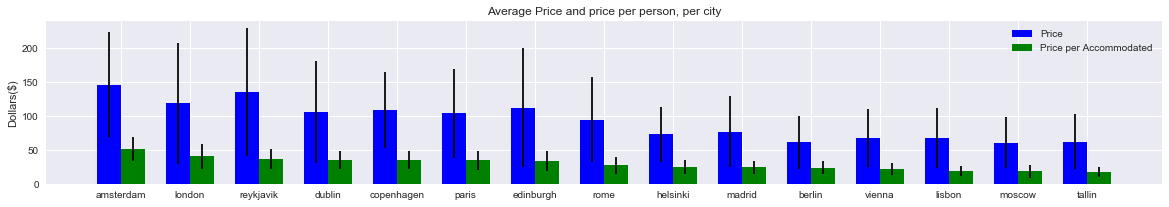

In [20]:
#creating bar chart showing the average prices and average prices per accommodated, per city
plt.clf()
N = len(datasets.keys())
price_means = []
price_stds = []
price_per_accommodated_means = []
price_per_accommodated_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    price_means.append(city_data['price'].mean())
    price_stds.append(city_data['price'].std())
    price_per_accommodated_means.append(city_data['price_per_accommodated'].mean())
    price_per_accommodated_stds.append(city_data['price_per_accommodated'].std())
    cities.append(city)


sort_indices = np.argsort(np.asarray(price_per_accommodated_means)) #sort cities on price per accommodated
price_means = list(np.asarray(price_means)[sort_indices[::-1]])
price_stds = list(np.asarray(price_stds)[sort_indices[::-1]])
price_per_accommodated_means = list(np.asarray(price_per_accommodated_means)[sort_indices[::-1]])
price_per_accommodated_stds = list(np.asarray(price_per_accommodated_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(20,3))

prices_bar = ax.bar(pos, tuple(price_means), width, color='b', yerr=tuple(price_stds))
prices_pa_bar = ax.bar(pos+width, tuple(price_per_accommodated_means), width, 
                       color='g', yerr=tuple(price_per_accommodated_stds))

ax.legend((prices_bar[0], prices_pa_bar[0]), ('Price', 'Price per Accommodated'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average Price and price per person, per city')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(tuple(cities))

plt.show()

In [21]:
'''
#creating bar chart showing the average price per accommodated, per room type, per city
plt.clf()
N = len(datasets.keys())
price_home_means = []
price_home_stds = []
price_proom_means = []
price_proom_stds = []
price_sroom_means = []
price_sroom_stds = []
cities = []

for city in datasets.keys():
    city_data = datasets[city]
    price_home_means.append(city_data[city_data['room_type'] == 'Entire home/apt'].mean())
    price_home_stds.append(city_data[city_data['room_type'] == 'Entire home/apt'].std())
    price_proom_means.append(city_data[city_data['room_type'] == 'Private room'].mean())
    price_proom_stds.append(city_data[city_data['room_type'] == 'Private room'].std())
    price_sroom_means.append(city_data[city_data['room_type'] == 'Shared room'].mean())
    price_sroom_stds.append(city_data[city_data['room_type'] == 'Shared room'].std())
    cities.append(city)

sort_indices = np.argsort(np.asarray(price_home_means)) #sort cities on entire home prices
price_home_means = list(np.asarray(price_home_means)[sort_indices[::-1]])
price_home_stds = list(np.asarray(price_home_stds)[sort_indices[::-1]])
price_proom_means = list(np.asarray(price_proom_means)[sort_indices[::-1]])
price_proom_stds = list(np.asarray(price_proom_stds)[sort_indices[::-1]])
price_sroom_means = list(np.asarray(price_sroom_means)[sort_indices[::-1]])
price_sroom_stds = list(np.asarray(price_sroom_stds)[sort_indices[::-1]])
cities = list(np.asarray(cities)[sort_indices[::-1]])


pos = np.arange(N)
width = 0.15

fig, ax = plt.subplots(figsize=(20,5))

home_bar = ax.bar(pos, tuple(price_home_means), width, color='b', yerr=tuple(price_home_stds))
proom_bar = ax.bar(pos+width, tuple(price_proom_means), width, 
                       color='g', yerr=tuple(price_proom_stds))
sroom_bar = ax.bar(pos+2*width, tuple(price_sroom_means), width, color='r', yerr=tuple(price_sroom_stds))

ax.legend((home_bar[0], proom_bar[0],sroom_bar[0]), ('Entire home/apt', 'Private room', 'Shared room'))

ax.set_ylabel('Dollars($)')
ax.set_title('Average Price per person, per room_type, per city')
ax.set_xticks(pos + width)
ax.set_xticklabels(tuple(cities))

plt.show()
'''

"\n#creating bar chart showing the average price per accommodated, per room type, per city\nplt.clf()\nN = len(datasets.keys())\nprice_home_means = []\nprice_home_stds = []\nprice_proom_means = []\nprice_proom_stds = []\nprice_sroom_means = []\nprice_sroom_stds = []\ncities = []\n\nfor city in datasets.keys():\n    city_data = datasets[city]\n    price_home_means.append(city_data[city_data['room_type'] == 'Entire home/apt'].mean())\n    price_home_stds.append(city_data[city_data['room_type'] == 'Entire home/apt'].std())\n    price_proom_means.append(city_data[city_data['room_type'] == 'Private room'].mean())\n    price_proom_stds.append(city_data[city_data['room_type'] == 'Private room'].std())\n    price_sroom_means.append(city_data[city_data['room_type'] == 'Shared room'].mean())\n    price_sroom_stds.append(city_data[city_data['room_type'] == 'Shared room'].std())\n    cities.append(city)\n\nsort_indices = np.argsort(np.asarray(price_home_means)) #sort cities on entire home prices\n

,index,room_id,host_id,room_type,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,last_modified,price_per_accommodated
0,1,18628,71597,Entire home/apt,Centro,Justicia,22,4.5,2,0.0,72.0,40.424715,-3.698638,2014-08-30 00:43:22.479000,36.000000
1,2,18730,71885,Entire home/apt,Centro,Cortes,40,4.5,10,3.0,237.0,40.414481,-3.701094,2014-08-29 21:42:37.119000,23.700000
2,3,19864,74966,Entire home/apt,Centro,Palacio,13,5.0,2,1.0,88.0,40.414879,-3.708782,2014-08-29 23:58:01.145000,44.000000
3,4,21512,82175,Entire home/apt,Moncloa,Argüelles,6,4.0,2,1.0,74.0,40.424920,-3.713446,2014-08-29 20:48:51.051000,37.000000
4,5,23021,82175,Entire home/apt,Moncloa,Argüelles,13,4.0,10,4.0,133.0,40.423417,-3.712456,2014-08-30 01:27:01.099000,13.300000
5,6,24805,101471,Entire home/apt,Centro,Universidad,0,5.0,3,1.0,103.0,40.422022,-3.703954,2014-08-30 01:18:51.155000,34.333333
6,7,24836,101653,Private room,Centro,Justicia,12,5.0,4,1.0,147.0,40.419989,-3.697614,2014-08-29 20:44:14.825000,36.750000
7,9,26571,112866,Private room,Fuencarral,Fuentelareina,0,4.5,3,1.0,66.0,40.476741,-3.739613,2014-08-30 00:50:57.717000,22.000000
9,11,26823,114340,Private room,Arganzuela,Legazpi,7,4.0,2,1.0,59.0,40.391161,-3.688234,2014-08-30 00:46:38.967000,29.500000
10,12,26825,114340,Private room,Arganzuela,Legazpi,22,4.5,1,1.0,29.0,40.389877,-3.688883,2014-08-30 00:49:22.204000,29.000000


In [36]:
datasets['madrid']

,index,room_id,host_id,room_type,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,last_modified,price_per_accommodated
0,1,18628,71597,Entire home/apt,Centro,Justicia,22,4.5,2,0.0,72.0,40.424715,-3.698638,2014-08-30 00:43:22.479000,36.000000
1,2,18730,71885,Entire home/apt,Centro,Cortes,40,4.5,10,3.0,237.0,40.414481,-3.701094,2014-08-29 21:42:37.119000,23.700000
2,3,19864,74966,Entire home/apt,Centro,Palacio,13,5.0,2,1.0,88.0,40.414879,-3.708782,2014-08-29 23:58:01.145000,44.000000
3,4,21512,82175,Entire home/apt,Moncloa,Argüelles,6,4.0,2,1.0,74.0,40.424920,-3.713446,2014-08-29 20:48:51.051000,37.000000
4,5,23021,82175,Entire home/apt,Moncloa,Argüelles,13,4.0,10,4.0,133.0,40.423417,-3.712456,2014-08-30 01:27:01.099000,13.300000
5,6,24805,101471,Entire home/apt,Centro,Universidad,0,5.0,3,1.0,103.0,40.422022,-3.703954,2014-08-30 01:18:51.155000,34.333333
6,7,24836,101653,Private room,Centro,Justicia,12,5.0,4,1.0,147.0,40.419989,-3.697614,2014-08-29 20:44:14.825000,36.750000
7,9,26571,112866,Private room,Fuencarral,Fuentelareina,0,4.5,3,1.0,66.0,40.476741,-3.739613,2014-08-30 00:50:57.717000,22.000000
9,11,26823,114340,Private room,Arganzuela,Legazpi,7,4.0,2,1.0,59.0,40.391161,-3.688234,2014-08-30 00:46:38.967000,29.500000
10,12,26825,114340,Private room,Arganzuela,Legazpi,22,4.5,1,1.0,29.0,40.389877,-3.688883,2014-08-30 00:49:22.204000,29.000000


In [39]:
for city in datasets.keys():
    city_data = datasets[city]
    city_data['last_modified'] = pd.to_datetime(city_data['last_modified'])
    city_data = city_data.sort_values(by='last_modified',ascending=True)
    datasets[city] = city_data.reset_index()
    

In [40]:
datasets['madrid']

,level_0,index,room_id,host_id,room_type,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,last_modified,price_per_accommodated
0,1126,1409,874496,1851138,Private room,Carabanchel,Buenavista,0,4.0,1,1.0,22.0,40.363591,-3.756468,2014-08-29 20:38:00.366000,22.000000
1,833,1037,745472,3909307,Entire home/apt,Centro,Embajadores,41,5.0,3,1.0,74.0,40.409333,-3.707138,2014-08-29 20:38:04.374000,24.666667
2,836,1040,745728,3797913,Entire home/apt,Centro,Palacio,0,5.0,12,4.0,369.0,40.418686,-3.709423,2014-08-29 20:38:07.256000,30.750000
3,1243,1555,943104,2312712,Private room,Barajas,Casco Histórico de Barajas,16,4.5,2,1.0,37.0,40.474142,-3.575571,2014-08-29 20:38:12.539000,18.500000
4,3302,4476,3572992,165406,Entire home/apt,Centro,Embajadores,0,4.5,7,3.0,96.0,40.409303,-3.708168,2014-08-29 20:38:22.320000,13.714286
5,178,210,240128,630482,Private room,Carabanchel,San Isidro,27,5.0,2,1.0,29.0,40.393764,-3.724827,2014-08-29 20:38:29.388000,14.500000
6,598,727,568320,2796507,Entire home/apt,Centro,Palacio,49,4.5,2,1.0,58.0,40.412792,-3.711251,2014-08-29 20:38:36.142000,29.000000
7,2300,2946,2144000,10940437,Shared room,Centro,Sol,11,4.5,8,1.0,27.0,40.414537,-3.707878,2014-08-29 20:38:42.137000,3.375000
8,2548,3295,2544640,13028010,Private room,Fuencarral,Valverde,0,0.0,1,1.0,37.0,40.497328,-3.689885,2014-08-29 20:38:49.084000,37.000000
9,205,250,282113,1470367,Private room,Centro,Palacio,66,5.0,2,1.0,59.0,40.420415,-3.709915,2014-08-29 20:39:13.211000,29.500000


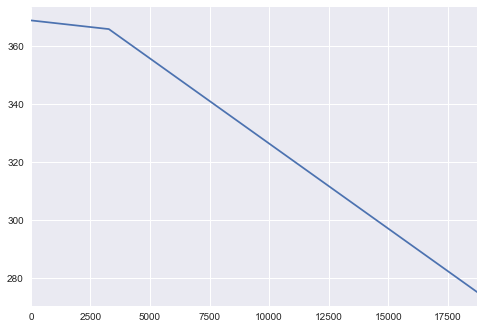

In [45]:
plt.clf()
city_data = datasets['madrid']
city_data.set_index('last_modified')
city_data[city_data['room_id'] == 745728]['price'].plot()
plt.show()